# Classification with Neural Networks 

**Author**

> - [Paul Schrimpf *UBC*](https://economics.ubc.ca/faculty-and-staff/paul-schrimpf/)  



**Prerequisites**

- [Classification](https://datascience.quantecon.org/../appplications/classification.html)  


**Outcomes**

- Use pytorch to classify images

In [1]:
# Uncomment following line to install on colab
#! pip install torch torchvision # TODO: THERE MIGHT BE MORE NEEDED

## Introduction

Neural networks can do a remarkably good job of recognizing images. We will explore a simple example here. 

A classic image recognition task is classifying hand written digits from the MNIST dataset.

## Data: MNIST

PyTorch includes convenient functions for downloading MNIST data.

In [3]:
import torch
import torchvision
import torch.nn as nn


# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])
#image datasets
train_dataset = torchvision.datasets.MNIST('dataset/', 
                                           train=True, 
                                           download=True,
                                           transform=image_transform)
test_dataset = torchvision.datasets.MNIST('dataset/', 
                                          train=False, 
                                          download=True,
                                          transform=image_transform)


9913344it [00:00, 27086755.62it/s]                             


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



29696it [00:00, 105517.17it/s]                           


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



1649664it [00:00, 2253613.31it/s]                             


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



5120it [00:00, 17859.13it/s]                          

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



The MNIST data consists of 28 by 28 pixel grayscale images of hand written digits. Let's look at some of them.

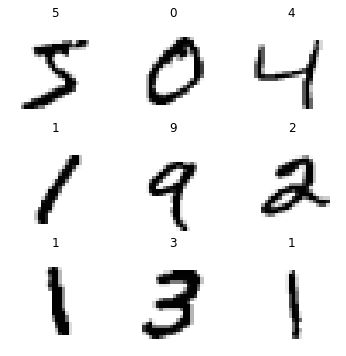

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3, 3, figsize=(6, 6))
for i, axi in enumerate(ax.flat):
  axi.imshow(train_dataset[i][0][0,:,:], cmap='gray_r')
  axi.set_title(train_dataset[i][1])
  axi.set_axis_off()

We now define our classification model. We will use a feed forward neural network. 

In [44]:
import itertools

device = 'cuda'
layers = [128, 64, 32] 
cmgslayers = [2500, 2000, 1500, 1000, 500]  # Ciresan et al (2010) architecture

def createmodel(layers):
  model = nn.Sequential(
    nn.Linear(28*28, layers[0]),
    nn.ReLU(),
    *itertools.chain.from_iterable(zip( (nn.Linear(layers[i-1], layers[i]) for i in range(1, len(layers))),
          (nn.ReLU() for i in range(1, len(layers))) )),
    nn.Linear(layers[-1], 10),
    nn.LogSoftmax(dim=1)
  )
  return model

model = createmodel(layers).to(device)

In [107]:
# prepare data for training 
batch_size_train = 5000  
batch_size_test = 5000 

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test, 
                                          shuffle=True)

In [108]:
# training
def train(model, epochs, train_loader, device):
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  model.train()

  losses = []
  for epoch in range(epochs):
    for batch_idx, (images, labels) in enumerate(train_loader):
      images = images.to(device).view(-1, 28*28)
      labels = labels.to(device)          
      optimizer.zero_grad()
      probs = model(images) 
      loss = nn.functional.cross_entropy(probs, labels)
      losses.append(loss.to('cpu').item())
      loss.backward()
      optimizer.step()
                
      
      if batch_idx % (len(train_loader)//10 +1) == 0:
        print('\n Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, 
                batch_idx * len(images), 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss), 
                end='')
            
  return losses

In [113]:
losses = train(model, 20, train_loader, device)


 Train Epoch: 0 [0/60000 (0%)]	Loss: 0.032852
 Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.043355
 Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.118863
 Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.045651
 Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.055464
 Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.060458
 Train Epoch: 1 [0/60000 (0%)]	Loss: 0.044754
 Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.032555
 Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.027344
 Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.027904
 Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.023094
 Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.021174
 Train Epoch: 2 [0/60000 (0%)]	Loss: 0.019049
 Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.014943
 Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.013038
 Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.016326
 Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.018714
 Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.017575
 Train Epoch: 3 [0/60000 (0%)]	Loss: 0.009886
 Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.006517

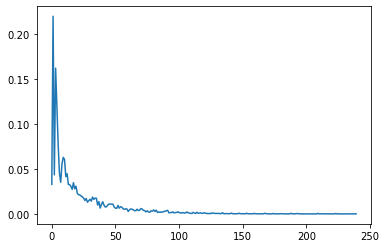

In [116]:
plt.plot(losses)

In [114]:
# testing accuracy
def accuracy(model, test_loader, device):
  model.eval()
  totalcorrect = 0
  total = 0
  for batch_idx, (images, labels) in enumerate(test_loader):
      images = images.to(device).view(-1, 28*28)
      labels = labels.to(device)                
      probs = model(images) 
      preds = probs.argmax(dim=1, keepdim=True)
      correct = preds.eq(labels.view_as(preds)).sum().item()
      totalcorrect += correct
      total += len(labels)
  return totalcorrect / total

accuracy(model, test_loader, 'cuda')



0.9793

[Performance of other models.](http://yann.lecun.com/exdb/mnist/)